In [216]:
#Check GPU
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-9e58ec82-e194-c014-5e52-ce1aa343e7eb)


#Add data

In [217]:
import zipfile
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data

zip_ref = zipfile.ZipFile("nlp_getting_started.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2021-10-28 09:05:39--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.97.128, 108.177.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.4’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.006s  

2021-10-28 09:05:39 (97.9 MB/s) - ‘nlp_getting_started.zip.4’ saved [607343/607343]



# EDA

In [218]:
pd.set_option("display.max_colwidth", -1)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [219]:
import pandas as pd
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [220]:
print(train_data.shape ,test_data.shape)
train_data.sample(frac=1,random_state=42).head()

(7613, 5) (3263, 4)


,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-imaginable destruction.,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3,0


In [221]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


 WE have 2 features that have NAN-values 





### Count plot

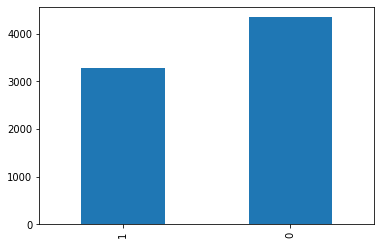

In [222]:
# Check our target is balenced or not!
train_data.target.value_counts().sort_values().plot(kind = 'bar')

### Visit some random data

In [223]:
import random
randomIndex = random.randint(0, len(train_data)-5) 
for row in train_data[["text", "target"]][randomIndex:randomIndex+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 0 (not real disaster)
Text:
@IAN_Hellfire I got it for the mistake but boss got it worse cause their job was to oversee my work. Boss didn't change after that...

---

Target: 0 (not real disaster)
Text:
That hellfire song from the hunchback of notre dame reminds me a lot of my house

---

Target: 0 (not real disaster)
Text:
the message you sent and they don't reply. I see that you saw my message the least you can do is tell me to 'fuck off' or something.

---

Target: 0 (not real disaster)
Text:
Beware of your temper and a loose tongue! These two dangerous weapons combined can lead a person to the Hellfire #islam!

---

Target: 0 (not real disaster)
Text:
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'

---



# Research for modeling

### split data

In [224]:
from sklearn.model_selection import train_test_split

xTrain, xVal, yTrain, yVal = train_test_split(train_data["text"].to_numpy(),
                                                                            train_data["target"].to_numpy(),
                                                                            test_size=0.15,
                                                                            random_state=55)
xTest = pd.read_csv('test.csv')
id = xTest['id']

### Text Vectorization

In [225]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

textVector = TextVectorization(max_tokens=None,
                                    standardize="lower_and_strip_punctuation", 
                                    split="whitespace",
                                    ngrams=None, 
                                    output_mode="int",
                                    output_sequence_length=None) 


In [226]:
# Find average number of tokens (words) in training Tweets
avrageWord = round(sum([len(i.split()) for i in xTrain])/len(xTrain))

In [227]:
textVector.adapt(xTrain)

In [228]:
textVector(['This is my first sentence'])

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[19,  9, 13, 96,  1]])>

In [312]:
# The most used vocab in data
textVector.get_vocabulary()[:20]

['',
 '[UNK]',
 'the',
 'a',
 'in',
 'to',
 'of',
 'and',
 'i',
 'is',
 'for',
 'on',
 'you',
 'my',
 'it',
 'that',
 'with',
 'at',
 'by',
 'this']

### Model 0 : Naive bayes

In [230]:
import tensorflow as tf

embedding = tf.keras.layers.Embedding(input_dim=1000,
                             output_dim=128,
                             embeddings_initializer="uniform",
                             input_length=avrageWord,
                             name="embedding_1")

embedding

In [231]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model0.fit(xTrain, yTrain)



Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [232]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Create a function for cal. score of our model ( will be used on other models)
def CalculateResults(yTrue, yPred):

  # Calculate model accuracy
  modelAccuracy = accuracy_score(yTrue, yPred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  modelPrecision, modelRecall, modelF1, _ = precision_recall_fscore_support(yTrue, yPred, average="weighted")
  modelResults = {"accuracy": modelAccuracy,
                  "precision": modelPrecision,
                  "recall": modelRecall,
                  "f1": modelF1}
  return modelResults

### Score model 0

In [233]:
yPred = model0.predict(xVal)
resualt0 = CalculateResults(yVal,yPred)

### Predict for kaggle score: 79.4

In [234]:
resualt = model0.predict(xTest['text'])
resualt = tf.squeeze(tf.round(resualt))
resaultDataframe = pd.DataFrame({'id':id,'target':resualt})
resaultDataframe.to_csv('submission.csv',index=False)

### Model 1

In [235]:
import datetime
def CreateTensorboardCallback(dirName, experimentName):

  logDir = dirName + "/" + experimentName + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboardCallback = tf.keras.callbacks.TensorBoard(
      log_dir=logDir
  )
  print(f"Saving TensorBoard log files to: {logDir}")
  return tensorboardCallback

In [236]:
SAVE_DIR = "model_logs"

In [237]:
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = textVector(inputs) # turn the input text into numbers
x = embedding(x) 
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model1 = tf.keras.Model(inputs, outputs, name="model_1_dense") 

In [238]:
# Compile model
model1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [239]:
# Fit the model
model1History = model1.fit(xTrain, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(dirName=SAVE_DIR, 
                                                                     experimentName="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20211028-090540
Epoch 1/5
203/203 [==============================] - 3s 11ms/step - loss: 0.6467 - accuracy: 0.6151 - val_loss: 0.5857 - val_accuracy: 0.7548
Epoch 2/5
203/203 [==============================] - 2s 8ms/step - loss: 0.5329 - accuracy: 0.7719 - val_loss: 0.4953 - val_accuracy: 0.7723
Epoch 3/5
203/203 [==============================] - 2s 8ms/step - loss: 0.4646 - accuracy: 0.8051 - val_loss: 0.4667 - val_accuracy: 0.7837
Epoch 4/5
203/203 [==============================] - 2s 8ms/step - loss: 0.4302 - accuracy: 0.8159 - val_loss: 0.4573 - val_accuracy: 0.7855
Epoch 5/5
203/203 [==============================] - 2s 8ms/step - loss: 0.4077 - accuracy: 0.8285 - val_loss: 0.4575 - val_accuracy: 0.7872


In [240]:
yPred = model1.predict(xVal)
yPred = tf.squeeze(tf.round(yPred))
resualt1 = CalculateResults(yVal,yPred)


### Visualizing embedding words

In [241]:
wordsInVocab = textVector.get_vocabulary()
embedWeights = model1.get_layer("embedding_1").get_weights()[0]
embedWeights.shape , len(wordsInVocab), wordsInVocab[:10]

((1000, 128),
 20255,
 ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [242]:
import io
# Create output writers
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(wordsInVocab[:1000]):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embedWeights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

http://projector.tensorflow.org/ visualizing data

### Model 2: LSTM


In [243]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model2Embedding = layers.Embedding(input_dim=1000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=avrageWord,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = textVector(inputs)
x = model2Embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, None, 128)
(None, 64)


In [244]:

# Compile model
model2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [245]:
model2History = model2.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20211028-090551
Epoch 1/5
203/203 [==============================] - 6s 20ms/step - loss: 0.5602 - accuracy: 0.7061 - val_loss: 0.4632 - val_accuracy: 0.7925
Epoch 2/5
203/203 [==============================] - 3s 13ms/step - loss: 0.4246 - accuracy: 0.8193 - val_loss: 0.4651 - val_accuracy: 0.7820
Epoch 3/5
203/203 [==============================] - 3s 14ms/step - loss: 0.4009 - accuracy: 0.8346 - val_loss: 0.4967 - val_accuracy: 0.7723
Epoch 4/5
203/203 [==============================] - 3s 14ms/step - loss: 0.3839 - accuracy: 0.8425 - val_loss: 0.4793 - val_accuracy: 0.7837
Epoch 5/5
203/203 [==============================] - 3s 13ms/step - loss: 0.3673 - accuracy: 0.8492 - val_loss: 0.4841 - val_accuracy: 0.7688


In [246]:
yPred2 = model2.predict(xVal)
yPred2 = tf.squeeze(tf.round(yPred2))
resualt2 = CalculateResults(yVal,yPred2)


### Model 3: GRU

In [247]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model3Embedding = layers.Embedding(input_dim=1000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=avrageWord,
                                     name="embedding_3")


# Create GRu model
inputs = layers.Input(shape=(1,), dtype="string")
x = textVector(inputs)
x = model3Embedding(x)
print(x.shape)

x = layers.GRU(64)(x) 
print(x.shape)

outputs = layers.Dense(1, activation="sigmoid")(x)
model3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, None, 128)
(None, 64)


In [248]:
# Compile GRU model
model3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [249]:
model3History = model3.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20211028-090615
Epoch 1/5
203/203 [==============================] - 6s 19ms/step - loss: 0.6608 - accuracy: 0.5999 - val_loss: 0.5142 - val_accuracy: 0.7706
Epoch 2/5
203/203 [==============================] - 3s 13ms/step - loss: 0.4599 - accuracy: 0.7979 - val_loss: 0.4609 - val_accuracy: 0.7925
Epoch 3/5
203/203 [==============================] - 3s 14ms/step - loss: 0.4078 - accuracy: 0.8292 - val_loss: 0.4937 - val_accuracy: 0.7811
Epoch 4/5
203/203 [==============================] - 3s 14ms/step - loss: 0.3885 - accuracy: 0.8397 - val_loss: 0.4795 - val_accuracy: 0.7837
Epoch 5/5
203/203 [==============================] - 3s 13ms/step - loss: 0.3730 - accuracy: 0.8516 - val_loss: 0.4839 - val_accuracy: 0.7785


In [250]:
yPred3 = model3.predict(xVal)
yPred3 = tf.squeeze(tf.round(yPred3))
resualt3 = CalculateResults(yVal,yPred3)


### Model 4: RNN bidirectional


In [251]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model4Embedding = layers.Embedding(input_dim=1000,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=avrageWord,
                                     name="embedding_4")


# Create RNN model
inputs = layers.Input(shape=(1,), dtype="string")
x = textVector(inputs)
x = model4Embedding(x)
print(x.shape)

x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)


model4 = tf.keras.Model(inputs, outputs, name="model_4_RNN")

(None, None, 128)


In [252]:

# Compile
model4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [253]:
model4History = model4.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "RNN")])

Saving TensorBoard log files to: model_logs/RNN/20211028-090634
Epoch 1/5
203/203 [==============================] - 10s 31ms/step - loss: 0.5326 - accuracy: 0.7251 - val_loss: 0.4498 - val_accuracy: 0.7942
Epoch 2/5
203/203 [==============================] - 4s 21ms/step - loss: 0.4139 - accuracy: 0.8200 - val_loss: 0.4571 - val_accuracy: 0.7828
Epoch 3/5
203/203 [==============================] - 4s 21ms/step - loss: 0.3899 - accuracy: 0.8336 - val_loss: 0.4744 - val_accuracy: 0.7758
Epoch 4/5
203/203 [==============================] - 4s 21ms/step - loss: 0.3743 - accuracy: 0.8404 - val_loss: 0.4697 - val_accuracy: 0.7802
Epoch 5/5
203/203 [==============================] - 4s 21ms/step - loss: 0.3511 - accuracy: 0.8447 - val_loss: 0.4771 - val_accuracy: 0.7688


In [254]:
yPred4 = model4.predict(xVal)
yPred4 = tf.squeeze(tf.round(yPred4))
resualt4 = CalculateResults(yVal,yPred4)


### Model 5: Transfer Learning


In [255]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder


In [256]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentenceEncoderLayer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [257]:
# Create model using the Sequential API
model5 = tf.keras.Sequential([
  sentenceEncoderLayer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
], name="model_5_USE")

# Compile model
model5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [258]:
model5History = model4.fit(xTrain,
                              yTrain,
                              epochs=5,
                              validation_data=(xVal, yVal),
                              callbacks=[CreateTensorboardCallback(SAVE_DIR, 
                                                                     "RNN")])

Saving TensorBoard log files to: model_logs/RNN/20211028-090731
Epoch 1/5
203/203 [==============================] - 6s 30ms/step - loss: 0.3277 - accuracy: 0.8642 - val_loss: 0.5336 - val_accuracy: 0.7609
Epoch 2/5
203/203 [==============================] - 4s 20ms/step - loss: 0.3070 - accuracy: 0.8717 - val_loss: 0.5238 - val_accuracy: 0.7688
Epoch 3/5
203/203 [==============================] - 4s 20ms/step - loss: 0.2820 - accuracy: 0.8841 - val_loss: 0.6026 - val_accuracy: 0.7539
Epoch 4/5
203/203 [==============================] - 4s 20ms/step - loss: 0.2688 - accuracy: 0.8838 - val_loss: 0.6040 - val_accuracy: 0.7426
Epoch 5/5
203/203 [==============================] - 4s 20ms/step - loss: 0.2426 - accuracy: 0.8983 - val_loss: 0.6063 - val_accuracy: 0.7434


In [259]:
yPred5 = model5.predict(xVal)
yPred5 = tf.squeeze(tf.round(yPred5))
resualt5 = CalculateResults(yVal,yPred5)


### Compare resaults

In [260]:

# Combine model results into a DataFrame
allModelRresults = pd.DataFrame({"naive": resualt0,
                                  "ANN": resualt1,
                                  "lstm": resualt2,
                                  "gru": resualt3,
                                  "RNN": resualt4,
                                  "transfer learning": resualt5,
})
allModelRresults = allModelRresults.transpose()
allModelRresults

,accuracy,precision,recall,f1
naive,79.159370,0.801303,0.791594,0.785103
ANN,78.721541,0.786869,0.787215,0.785288
lstm,76.882662,0.768848,0.768827,0.765824
gru,77.845884,0.781198,0.778459,0.774090
RNN,76.882662,0.768026,0.768827,0.766782
transfer learning,47.635727,0.563600,0.476357,0.411437


### Remove Punctaution

In [275]:
import string 

# Create a function for removing punctuation
def RemovePunctaution(text):
    noPunctaution = [words for words in text if words not in string.punctuation]
    return ''.join(noPunctaution)

# Data processing and modeling with best of models

### Convert uppercsae to lowercase

In [262]:

# Make a fucntion for convert Upper letter to lower letter
def UpperToLower(text):
    noUpperCase = [words.lower() for words in text]
    return ''.join(noUpperCase)


In [263]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Testing nltk 
stopWords = nltk.corpus.stopwords.words('english')
len(stopWords)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


179

### Stopwords

In [264]:

# Create a Function for removing stop word

def RemoveStopWords(text):
  stopWords = nltk.corpus.stopwords.words('english')
  noStopWords = [word for word in text if word not in stopWords]
  return noStopWords


### Tokenizing

In [301]:
import nltk
from nltk.tokenize import word_tokenize

def Tokening(string):
  tokens = word_tokenize(string)
  return tokens

## Spell Correction

In [266]:
! python -m pip install -U symspellpy

In [267]:
!curl -LJO https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_dictionary_en_82_765.txt
!curl -LJO https://raw.githubusercontent.com/mammothb/symspellpy/master/symspellpy/frequency_bigramdictionary_en_243_342.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1300k  100 1300k    0     0  2762k      0 --:--:-- --:--:-- --:--:-- 2762k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5016k  100 5016k    0     0  6239k      0 --:--:-- --:--:-- --:--:-- 6232k


In [279]:
from symspellpy import SymSpell, Verbosity

symSpell = SymSpell()
PATH = "./frequency_dictionary_en_82_765.txt"
symSpell.load_dictionary(PATH,0,1)
def SpellingCorrection(sent):
  correctSpelling = []
  for word in sent.split(" "):
    x = symSpell.lookup(word,Verbosity.CLOSEST, max_edit_distance=2,include_unknown=True)[0].__str__()
    y = x.split(',')[0]
    correctSpelling.append(y)
  return correctSpelling


In [269]:
string = ' hello my nam is joj wha is yo name and what ar yo doin'
SpellingCorrection(string)


a, 1, 9081174698
hello, 0, 32960381
my, 0, 1059793441
nam, 0, 7037733
is, 0, 4705743816
job, 1, 177706929
what, 1, 812395582
is, 0, 4705743816
to, 1, 12136980858
name, 0, 464532702
and, 0, 12997637966
what, 0, 812395582
a, 1, 9081174698
to, 1, 12136980858
down, 1, 224915894


['a',
 'hello',
 'my',
 'nam',
 'is',
 'job',
 'what',
 'is',
 'to',
 'name',
 'and',
 'what',
 'a',
 'to',
 'down']

In [280]:
from symspellpy import SymSpell, Verbosity

symSpell = SymSpell()
PATH = "./frequency_dictionary_en_82_765.txt"
symSpell.load_dictionary(PATH,0,1)
def SpellingRemover(sent):
  correctSpelling = []
  for word in sent.split(" "):
    x = symSpell.lookup(word,Verbosity.CLOSEST, max_edit_distance=2,include_unknown=True)[0].__str__()
    if x.split(',')[1]==' 0':
      correctSpelling.append(word)

  return correctSpelling


### Lemmatization

In [281]:
import nltk
from nltk.stem import WordNetLemmatizer

def Lemmatizer(vector):
  lemmatizer = WordNetLemmatizer()
  lemmatizeWords = [lemmatizer.lemmatize(word) for word in vector]
  return lemmatizeWords

### Convert to text

In [282]:
def ConvertArrayToText(vector):
  return ' '.join(vector)

### Make pipline

In [302]:
import re
def Pipline(data):
  data['text-after-cleaning'] = data['text'].apply(lambda x : re.sub(r'@\w+','',x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x :re.sub(r"http\S+", '', x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x :re.sub(r"[0-9]+", '', x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x : RemovePunctaution(x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x : UpperToLower(x))
  # Dosen't work very well
  # data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x : SpellingRemover(x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x : Tokening(x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x : RemoveStopWords(x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x : Lemmatizer(x))
  data['text-after-cleaning'] = data['text-after-cleaning'].apply(lambda x : ConvertArrayToText(x))

 


In [303]:
Pipline(train_data)
Pipline(xTest)


In [304]:
import random
randomIndex = random.randint(0, len(train_data)-5) 
for row in train_data[["text-after-cleaning", "target"]][randomIndex:randomIndex+5].itertuples():
  _, text, target = row
  print(f'Original: {train_data.text.iloc[[row[0]]]}')
  print(f"row : {randomIndex} Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Original: 6466    @aphyr IÛªve been following you this longÛ_ Sunk cost fallacy or somethinÛª
Name: text, dtype: object
row : 6466 Target: 0 (not real disaster)
Text:
iûªve following longû sunk cost fallacy somethinûª

---

Original: 6467    descended or sunk however it may be to the shadowed land beyond the crest of a striking cobra landing harshly upon his back; torch and
Name: text, dtype: object
row : 6466 Target: 0 (not real disaster)
Text:
descended sunk however may shadowed land beyond crest striking cobra landing harshly upon back torch

---

Original: 6468    So if I capsize on your thighs high tide B-5 you sunk my battleship\n&gt;
Name: text, dtype: object
row : 6466 Target: 0 (not real disaster)
Text:
capsize thigh high tide b sunk battleship gt

---

Original: 6469    has NOT sunk in that i leave for school in a month
Name: text, dtype: object
row : 6466 Target: 0 (not real disaster)
Text:
sunk leave school month

---

Original: 6470    It still hasn't sunk in that i 

### Use best model

In [314]:
from sklearn.model_selection import train_test_split

xTrain = train_data['text-after-cleaning']
yTrain = train_data['target']

id = xTest['id']

In [315]:
# reuse best model 
model0.fit(xTrain, yTrain)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [316]:
resualt = model0.predict(xTest['text-after-cleaning'])
resualt = tf.squeeze(tf.round(resualt))
resaultDataframe = pd.DataFrame({'id':id,'target':resualt})
resaultDataframe.to_csv('submission.csv',index=False)